# Full Source Code
This notebook is a complete rewrite of the original source and provides improvements in order to streamline, modify, and simplify the build process. Full validation and optimization of the original models will be included.

**GT CSE 6250 Spring Project**
Team A1: Brian Popp, bpopp7@gatech.edu, Danielle Velott, dvellot3@gatech.edu


In [2]:
# GT CSE 6250 Spring Project
# Team A1: Brian Popp, bpopp7@gatech.edu, Danielle Velott, dvellot3@gatech.edu
import os
import string
from nltk import word_tokenize
from gensim.models import KeyedVectors, Word2Vec
import numpy as np

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, MaxPool2D
from keras.layers import Conv2D, GlobalAveragePooling1D, MaxPooling2D
from keras.layers import Concatenate
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

## our imports
import pandas as pd
import re
from itertools import chain, repeat, islice
import requests
import matplotlib.pyplot as plt
import io

import nltk
nltk.download('punkt')

## utility functions
def pad_infinite(iterable, padding=None):
   return chain(iterable, repeat(padding))

def pad(iterable, size, padding=None):
   return islice(pad_infinite(iterable, padding), size)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bpopp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
## Using the same variable declarations and configuration options as the original study
ip_txt_file = './data/500_Reddit_users_posts_labels.csv'  # CSV file: "User", "Post", "Label"
ip_feat_file = './data/External_Features.csv'             # CSV file: "User", "Features"
limit_rows = 180   ## used to build a partial dataset

w2v_file = {'file': './out/numberbatch-en-19.08.txt.gz', 
            'is_binary': False, 
            'limit': None, 
            'cache': './out/vectors.kv', 
            'source':'https://conceptnet.s3.amazonaws.com/downloads/2019/numberbatch/numberbatch-en-19.08.txt.gz' }

op_file = './out/Result_5-Label_Classification.tsv'
severity_classes = {'Supportive': 0, 'Indicator': 1, 'Ideation': 2, 'Behavior': 3, 'Attempt': 4}

sys_params = {'emb_dim': 300,
              'max_sent_len': 1500,
              'str_padd': '@PADD',
              'cross_val': 5}

cnn_params = {'no_filters': 100,
              'kernels': [3, 4, 5],
              'channel': 1,
              'c_stride': (1, sys_params['emb_dim']),
              'pad': 'same',
              'ip_shape': (sys_params['max_sent_len'], sys_params['emb_dim'], 1),
              'c_activ': 'relu',
              'drop_rate': 0.3,
              'dense_1_unit': 128,
              'dense_2_unit': 128,
              'dense_activ': 'relu',
              'op_unit': 5,             # 5-Label classification
              'op_activ': 'softmax',
              'l_rate': 0.001,
              'loss': 'categorical_crossentropy',
              'batch': 4,
              'epoch': 50,
              'verbose': 1}

intermediate_layer = 'flat_drop'    # for extracting features from CNN

In [9]:
def get_keras_cnn_model():

    input = Input(shape=(sys_params['max_sent_len'], sys_params['emb_dim'], 1), dtype='float32')
    
    conv_layers = []
    for filter in cnn_params['kernels']:
        conv2d = Conv2D(filters=cnn_params['no_filters'], kernel_size=(filter, sys_params['emb_dim']), strides=cnn_params['c_stride'],
                        padding=cnn_params['pad'], data_format='channels_last', input_shape=cnn_params['ip_shape'],
                        activation=cnn_params['c_activ'])(input)
        l_pool = MaxPool2D(pool_size=(sys_params['max_sent_len'], 1))(conv2d)
        conv_layers.append(l_pool)
        
    l_concat = Concatenate(axis=1)(conv_layers)
    l_flat = Flatten()(l_concat)
    l_drop = Dropout(rate=cnn_params['drop_rate'], name='flat_drop')(l_flat)
    output = Dense(units=cnn_params['op_unit'], activation=cnn_params['op_activ'], name='cnn_op')(l_drop)
    
    final_model = Model(input, output)
    final_model.compile(optimizer=Adam(learning_rate=cnn_params['l_rate']), loss=cnn_params['loss'], metrics=['accuracy'])   
    
    return final_model

def get_prf1_score(y_true, y_pred):
    tp, fp, fn = 0.0, 0.0, 0.0
    for i in range(len(y_pred)):
        if y_pred[i] == y_true[i]:
            tp += 1
        elif y_pred[i] > y_true[i]:
            fp += 1
        else:
            fn += 1
    if tp == 0:
        tp = 1.0
    if fp == 0:
        fp = 1.0
    if fn == 0:
        fn  = 1.0
    P = tp / (tp + fp)
    R = tp / (tp + fn)
    F = 2 * P * R / (P + R)
    return P, R, F


## Primary Dataset
The study's primary dataset is 500 rows of de-identified social media posts discussing various aspects of self-destructive behavior. Each row has a user id, the text of the post, and a label describing how the post was manually classified.      

In [10]:
df = pd.read_csv ( ip_txt_file ).loc[:limit_rows]
df.head(2)

,User,Post,Label
0,user-0,"['Its not a viable option, and youll be leavin...",Supportive
1,user-1,['It can be hard to appreciate the notion that...,Ideation


## Cleanup
The original study provided code to do the word tokenization, but it was based on an older version of python and honestly wasn't very efficient. We've cleaned this up a bit by converting to pandas and using more pythonic transformations. 

In [11]:
df['post_clean'] = df.Post.str.lower() # convert to lowercase
df['post_clean'] = df.post_clean.str.replace("/[^ -~]+/g","", regex=True) ## remove non-printable
df["post_clean"] = df.post_clean.str.replace('[^\w\s]','', regex=True) ## remove punctuation
df["post_clean"] = df.post_clean.apply(word_tokenize) ## tokenize
df["post_clean"] = df.post_clean[:sys_params['max_sent_len']] # limit length
df["post_clean"] = df.post_clean.apply ( lambda x : list(pad(x, sys_params['max_sent_len'], sys_params['str_padd']))) ## pad list

df['LabelCode'] = df.Label.map ( severity_classes ) ## map labels to codes

labels = np.array (df.LabelCode.values)
print ( 'labels:', labels[:5] )

posts = np.array(df.post_clean.values.tolist())
print ( 'posts: ', posts[:5] )

labels: [0 2 3 4 2]
posts:  [['its' 'not' 'a' ... '@PADD' '@PADD' '@PADD']
 ['it' 'can' 'be' ... 'my' 'studies' 'and']
 ['hi' 'so' 'last' ... '@PADD' '@PADD' '@PADD']
 ['i' 'tried' 'to' ... '@PADD' '@PADD' '@PADD']
 ['hi' 'nem3030' 'what' ... '@PADD' '@PADD' '@PADD']]


## Vectorize
Features are built by mapping word tokens to vectors of similar words. These similarities are taken from pre-built
similarity vectors. For this study, the authors used a popular open-source project called ConceptNet. From their documentation:

> ConceptNet is a freely-available semantic network, designed to help computers 
> understand the meanings of words that people use.

We've improved on the study's code by allowing these vectors to be automatically downloaded and by caching word 
vectors to significantly reduce loading time.

In [12]:
if (w2v_file['cache'] != "") & (os.path.isfile ( w2v_file['cache']) ):
    print ( "Using cached vectors." )
    w2v_model = KeyedVectors.load(w2v_file['cache'])
else:
    if not os.path.isfile ( w2v_file['file'] ):
        print ( f"Could not find {w2v_file['file']}.. attempting download from {w2v_file['source']}." )
        r = requests.get(w2v_file['source'], allow_redirects=True)
        open ( w2v_file['file'], 'wb').write ( r.content )
    
    print ( "Loading vectors... this will take a few minutes.." )
    w2v_model = KeyedVectors.load_word2vec_format(w2v_file['file'], binary=w2v_file['is_binary'], limit=w2v_file['limit'])
    if w2v_file['cache'] != "":
        w2v_model.save( w2v_file['cache'] )

w2v_model


Using cached vectors.


In [13]:
vocab = w2v_model.key_to_index
padding = np.zeros(sys_params['emb_dim'], dtype='float32')

vectors = []
for sentence in posts:
    vector = []
    for tok in sentence:
        if tok==sys_params['str_padd']:
            vector.append(list(padding))
        
        elif tok in vocab:
            vector.append(w2v_model[tok].astype(float).tolist())
    
        else:
            vector.append(list(padding))
    
    vectors.append(vector)   
    
x_data, y_data = np.array(vectors), np.array ( labels )
print ( x_data.shape, y_data.shape )


(181, 1500, 300) (181,)


## Save the Dataset

In [14]:
x_data_all = x_data.reshape(x_data.shape[0], x_data.shape[1], x_data.shape[2], 1)
y_data_all = labels

np.savez_compressed ( f'./data/smalldataset.npz', x=x_data_all, y=y_data_all )

## Load the Dataset

In [17]:
dataset = np.load ( './data/smalldataset.npz' )
x_data_all = dataset['x']
y_data_all = dataset['y']
y_data_df = pd.DataFrame ( dataset['y'] )
print ( x_data_all.shape, y_data_all.shape )

(181, 1500, 300, 1) (181,)


## Show the Model

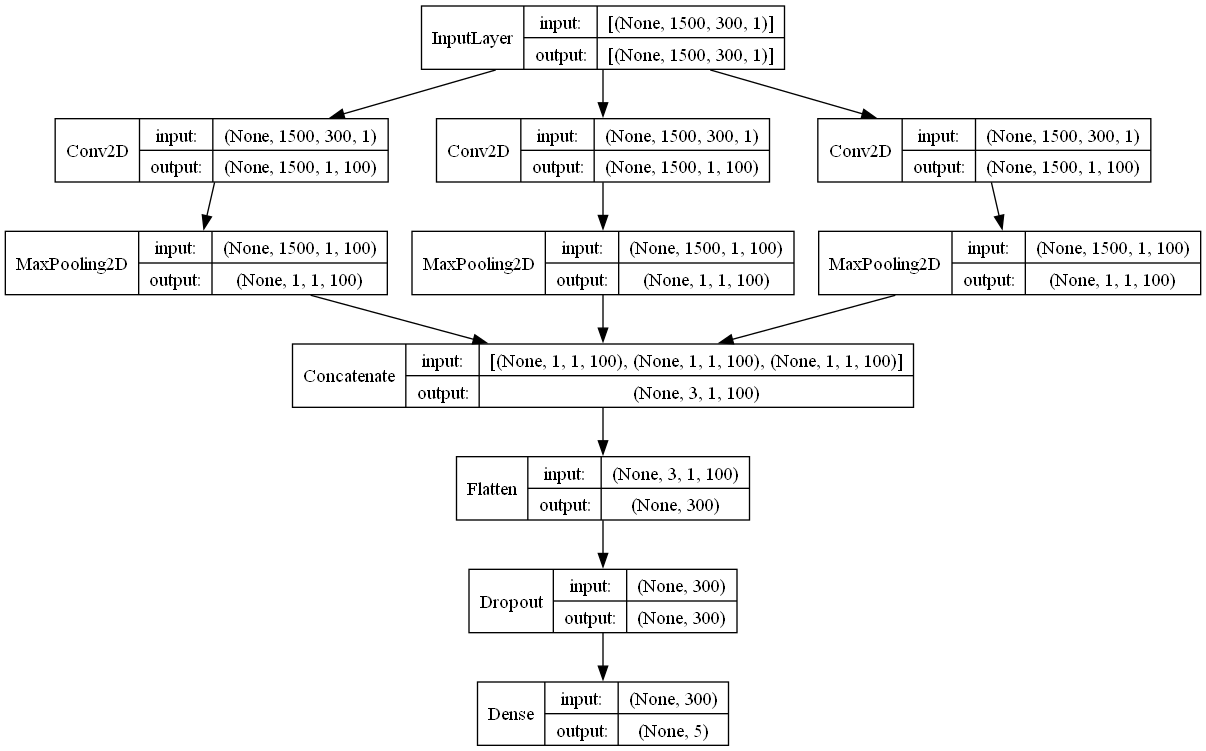

In [15]:
model = get_keras_cnn_model()
from keras.utils import plot_model
plot_model(model, to_file='images/5category_cnn_model.png', show_shapes=True, show_layer_names=False)


## Run the Model (simple)

train: (135, 1500, 300, 1) (135, 1)
test: (46, 1500, 300, 1) (46, 1)
Epoch 1/3
34/34 [==============================] - 6s 139ms/step - loss: 1.6156 - accuracy: 0.3333
Epoch 2/3
34/34 [==============================] - 5s 151ms/step - loss: 1.4393 - accuracy: 0.3630
Epoch 3/3
2/2 [==============================] - 1s 130ms/step

Precision: 0.594	 Recall: 0.576	 F1-Score: 0.585


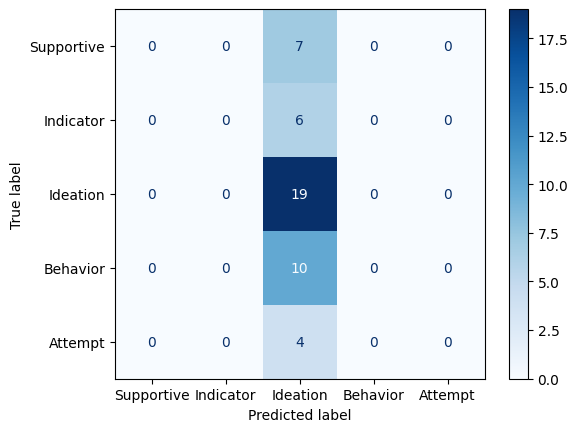

In [35]:
x_train, x_test, y_train, y_test = train_test_split( x_data_all , y_data_df, test_size=0.25)
print ( 'train:', x_train.shape, y_train.shape )
print ( 'test:', x_test.shape, y_test.shape )

epochs = 3 #cnn_params['epoch']
cnn_model = get_keras_cnn_model()
cnn_model.fit(x=x_train, y=to_categorical(y_train), batch_size=4, epochs=epochs, verbose=1)

y_pred = cnn_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1) ## find the classifier with the highest probability
y_true = y_test.values

precision, recall, f1 = get_prf1_score(y_true, y_pred)
print ('\nPrecision: {0}\t Recall: {1}\t F1-Score: {2}'\
    .format(round(precision,3), round(recall,3), round(f1,3)))

ConfusionMatrixDisplay(confusion_matrix ( y_true, y_pred ), 
          display_labels=list(severity_classes.keys()) )\
  .plot(cmap=plt.cm.Blues);

## Run the Model (KFold Cross Validation)

In [33]:
epochs=1
scores = []

skf = StratifiedKFold(n_splits=sys_params['cross_val'])
skf.get_n_splits(x_data_all, y_data_all)


for cv_count, (train_index, test_index) in enumerate(skf.split(x_data_all, y_data_all), start=1):
    print ('\nRunning Stratified Cross Validation: {0}/{1}...'.format(cv_count, sys_params['cross_val']))

    x_train, x_test = x_data_all[train_index], x_data_all[test_index]
    y_train, y_test = y_data_all[train_index], y_data_all[test_index]

    cnn_model = get_keras_cnn_model()
    cnn_model.fit(x=x_train, y=to_categorical(y_train), batch_size=4, epochs=epochs, verbose=1)
    
    y_pred = cnn_model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = y_test

    precision, recall, f1 = get_prf1_score(y_true, y_pred)
    print ('\nPrecision: {0}\t Recall: {1}\t F1-Score: {2}'\
        .format(round(precision,3), round(recall,3), round(f1,3)))

    scores.append({'I':cv_count, 'Precision':precision, 'Recall':recall, 'F1':f1})

sumdf = pd.DataFrame ( scores ).set_index('I')
sumdf.loc['Average'] = sumdf.mean()
display ( sumdf )

# print ('\nAverage Precision: {0}\t Recall: {1}\t F1-Score: {2}'\
#        .format(round(sumdf.P.mean(),3), round(sumdf.R.mean(),3), round(sumdf.F.mean(),3)))



Running Stratified Cross Validation: 1/5...
2/2 [==============================] - 0s 48ms/step
[0 2 3 4 2 0 0 2 0 2 1 0 3 2 2 3 2 3 4 2 0 2 2 0 4 1 2 2 2 3 3 1 3 1 3 1 1] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

Precision: 0.5	 Recall: 0.542	 F1-Score: 0.52

Running Stratified Cross Validation: 2/5...
2/2 [==============================] - 0s 49ms/step
[4 0 4 0 2 2 2 0 0 2 4 2 2 4 2 0 0 2 2 2 0 2 2 3 2 3 3 3 3 1 3 3 1 1 1 1] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

Precision: 0.52	 Recall: 0.542	 F1-Score: 0.531

Running Stratified Cross Validation: 3/5...
2/2 [==============================] - 0s 42ms/step
[4 4 2 0 2 0 0 2 0 2 0 2 4 2 3 0 0 4 2 3 3 3 2 2 3 3 3 2 2 2 2 1 1 1 1 1] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

Precision: 0.52	 Recall: 0.542	 F1-Score: 0.531

Running Stratified Cross Validation: 4/5...
2/2 [==============================] - 1s 39ms/step
[4 3 0 3 3 2 3 4 0 

,Precision,Recall,F1
I,,,
1,0.500000,0.541667,0.520000
2,0.520000,0.541667,0.530612
3,0.520000,0.541667,0.530612
4,0.500000,0.565217,0.530612
5,0.538462,0.583333,0.560000
Average,0.515692,0.554710,0.534367


## Improved Model

In [26]:
x_train, x_test, y_train, y_test = train_test_split( x_data_all , y_data_df, test_size=0.25)
print ( 'train:', x_train.shape, y_train.shape )
print ( 'test:', x_test.shape, y_test.shape )

train: (135, 1500, 300, 1) (135, 1)
test: (46, 1500, 300, 1) (46, 1)


Epoch 1/5
34/34 [==============================] - 6s 138ms/step - loss: 1.5787 - accuracy: 0.3407
Epoch 2/5
34/34 [==============================] - 5s 146ms/step - loss: 1.4016 - accuracy: 0.4222
Epoch 3/5
34/34 [==============================] - 5s 142ms/step - loss: 1.2537 - accuracy: 0.5407
Epoch 4/5
34/34 [==============================] - 5s 143ms/step - loss: 1.0663 - accuracy: 0.6593
Epoch 5/5
2/2 [==============================] - 1s 143ms/step


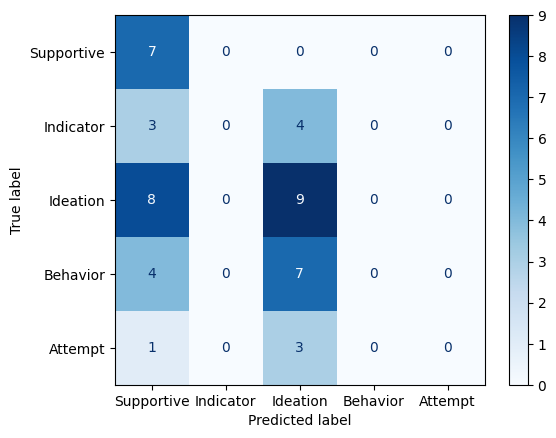

In [27]:
epochs = 5
input_shape = (1500,300,1)
input = Input(shape=input_shape, dtype='float32')
conv_layers = []
for filter in [3,4,5]:
    conv2d = Conv2D(filters=100, kernel_size=(filter, 300), strides=(1, 300),
                    padding='same', data_format='channels_last', input_shape=input_shape,
                    activation='relu')(input)
    conv_layers.append ( MaxPool2D(pool_size=(1500, 1))(conv2d) )

l_concat = Concatenate(axis=1)(conv_layers)
l_flat = Flatten()(l_concat)
l_drop = Dropout(rate=0.3, name='flat_drop')(l_flat)
output = Dense(units=5, activation='softmax', name='cnn_op')(l_drop)

m = Model(input, output)
m.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
m.fit(x=x_train, y=to_categorical(y_train), batch_size=4, epochs=epochs, verbose=1)

y_pred = m.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1) ## find the predicted classifier with the highest probability
y_true = y_test.values ## convert back to numpy

ConfusionMatrixDisplay(confusion_matrix ( y_true, y_pred ),
          display_labels=list(severity_classes.keys()) )\
  .plot(cmap=plt.cm.Blues);
